# Import 및 기능 함수
(아래 모듈에서 사용하는 함수로 따로 호출하지 말것)

In [ ]:
import os
import math
import numpy as np
import pandas as pd

from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix, f1_score, average_precision_score,roc_curve, auc,precision_recall_curve


In [ ]:
def print_(num,text=''):
  if num <=1:
    print('%13.10s : %8.4f'%(text,num) )
  else:
    print('%13.10s : %8.4d'%(text,num) )


In [ ]:
def predict_at_threshold(prob, threshold):
    return np.where(prob >= threshold, 1., 0.)

def precision_at_threshold(Y, prob, threshold):
    Y_hat = predict_at_threshold(prob, threshold)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y_hat)

def recall_at_threshold(Y, prob, threshold):
    Y_hat = predict_at_threshold(prob, threshold)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y)

def precision_recall_curve(Y, prob):
    unique_thresh = np.unique(prob)
    precision = [precision_at_threshold(Y, prob, t) for t in unique_thresh]
    recall = [recall_at_threshold(Y, prob, t) for t in unique_thresh]
    return precision, recall, unique_thresh

# 기본 매트릭 정보 출력

In [1]:
def show_metrics(x_test, y_test, model):
  #예측값
  y_pred = model.predict(x_test)

  result = pd.DataFrame({'pred':np.array(y_pred).reshape(-1), 'ans':np.array(y_test)})

  target_name =['Poor','Standard','Good']
  
  metrics = {
      'True_Positive' :[],
      'True_Negative' :[],
      'False_Positive' :[],
      'False_Negative' :[],
      'recall':[],
      'precision':[], 
      'accuracy':[],
      'f1_score':[],
      'confusion':[],
             }


  for i in range(3):
    # 예측과 결과가 동일
    t_df = result.loc[result['pred']==result['ans']]
    # 예측과 결과 다름
    f_df = result.loc[result['pred']!=result['ans']]


    #tp,tn,fn,fp 계산
    tp = len(t_df.loc[t_df['pred']==i])
    tn = len(t_df.loc[t_df['pred']!=i])
    fn = len(f_df.loc[f_df['pred']!=i])
    fp = len(f_df.loc[f_df['pred']==i])


    #매트릭 계산
    confusion = np.array([[tp,fn],[fp,tn]])
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp /(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    
    #주요 매트릭 저장
    metrics['True_Positive'].append(tp)
    metrics['True_Negative'].append(tn)
    metrics['False_Positive'].append(fp)
    metrics['False_Negative'].append(fn)

    metrics['confusion'].append(confusion)
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1_score)
    

  #출력
  for i in range(3):
    print(f'\n\n================ {target_name[i]}  vs other score ==================')
    for num,key in enumerate(metrics) :
      if key !='confusion':
        print_(metrics[key][i],key)
      else:
        print('confusion_mat\n',metrics[key][i],'\n')
  
  plt.figure(figsize=(20, 10))
  idx =1
  for key in metrics:
    if key !='confusion':

      plt.subplot(2,4,idx)
      idx= idx+1

      plt.title(f'{key}')
      #평균 선 
      plt.axhline(y=sum(metrics[key])/3, color='r', linestyle='--', linewidth=1)
      
      # bar plot 
      dist = (max(metrics[key])-min(metrics[key]))/2
      plt.ylim([min(metrics[key])-dist, max(metrics[key])+dist])
      plt.bar(target_name,metrics[key],color=['pink','lightgray','skyblue'])

      # label 삽입
      for num,height in enumerate(metrics[key]):
        if height <=1:
          plt.text(target_name[num], height, '%.3f' % height, ha='center', va='bottom', size = 12)
        else:
          plt.text(target_name[num], height, '%.3d' % height, ha='center', va='bottom', size = 12)


  plt.show()




================ Poor  vs other score ==================
confusion : [[ 5174  5253]
 [ 2123 12450]]
recall : 0.496
precision : 0.709
accuracy : 0.705
f1_score : 0.584


================ Standard  vs other score ==================
confusion : [[9394 3775]
 [3601 8230]]
recall : 0.713
precision : 0.723
accuracy : 0.705
f1_score : 0.718


================ Good  vs other score ==================
confusion : [[ 3056  5724]
 [ 1652 14568]]
recall : 0.348
precision : 0.649
accuracy : 0.705
f1_score : 0.453


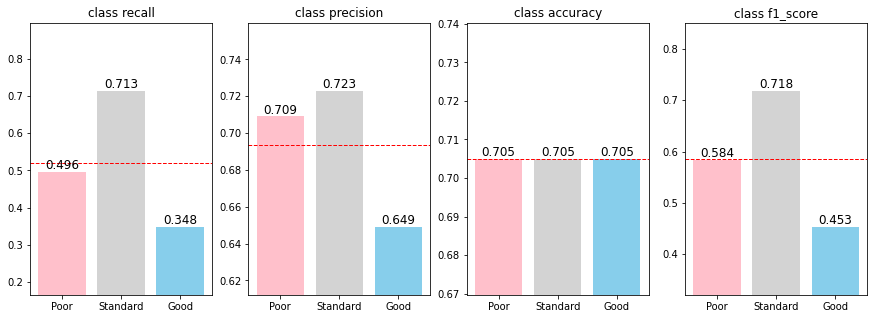

In [ ]:
# show_metrics(x_test,y_test,model_smote_base)

# PR 커브

In [2]:

def draw_pr_curve(x_test,y_test,model,overlap=False):
  '''
  PR CURVE 그리는 함수

  Param:
    - x_test : pred를 위한 데이터
    - y_test : X_test의 결과데이터
    - model : 예측 모델
    - overlab : plot 결과를 합쳐서 볼지 아닐지 (True/False)

  '''
  from sklearn.metrics import average_precision_score

  # class별 one vs other을 위한 dummies 생성
  y_test_dummies = pd.get_dummies(y_test).values

  if overlap == False:
    plt.figure(figsize=(15, 5))
  else:
    plt.figure(figsize=(5, 5))

  n_classes = 3
  class_name = ['Poor','Standard','Good']
  color=['pink','lightgray','skyblue']

  precision = {}
  recall = {}
  average_precision = {}
  for i in range(n_classes):
    #metric 계산
    precision[i], recall[i], threshold = precision_recall_curve(y_test_dummies[:,i],  model.predict_proba(x_test)[:, i])
    average_precision[i] = average_precision_score(y_test_dummies[:,i], model.predict_proba(x_test)[:, i])
    area = auc(recall[i],precision[i])

    # subplot 생성
    if overlap == False:
      plt.subplot(1,3,i+1)
    else:
      plt.legend()
    plt.plot(np.array(recall[i]),
             np.array(precision[i]),
             color=color[i],
            label= f'PR curve (area = {area})')

    #plot setting
    plt.fill_between(np.array(recall[i]), np.array(precision[i]), alpha=0.5,color=color[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Class :{class_name[i]}')
    plt.legend()

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_dummies, model.predict_proba(x_test))
  average_precision["micro"] = average_precision_score(y_test_dummies, model.predict_proba(x_test), average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.4f}'.format(average_precision["micro"]))
  plt.show()


In [ ]:
def micro_ap_score(x_test, y_test, model):
    from sklearn.metrics import average_precision_score
    n_classes = len(np.unique(y_test))
    y_test_dummies = pd.get_dummies(y_test).values
    y_score = model.predict_proba(x_test)
    print("y _score: ", y_score)
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i], y_score[:, i])
        print('precision, recall')
        average_precision[i] = average_precision_score(y_test_dummies[:, i], y_score[:, i])
        print('average precision')

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_dummies, y_score
    )
    average_precision["micro"] = average_precision_score(y_test_dummies, y_score, average="micro")

    print('Micro weighted average score : {}'.format(average_precision["micro"]))

    return average_precision["micro"]

In [ ]:

# def draw_pr_curve(x_test,y_test,model,overlap=False):
#   '''
#   PR CURVE 그리는 함수
#
#   Param:
#     - x_test : pred를 위한 데이터
#     - y_test : X_test의 결과데이터
#     - model : 예측 모델
#     - overlab : plot 결과를 합쳐서 볼지 아닐지 (True/False)
#
#   '''
#
#   # class별 one vs other을 위한 dummies 생성
#   y_test_dummies = pd.get_dummies(y_test).values
#
#   if overlap == False:
#     plt.figure(figsize=(15, 5))
#   else:
#     plt.figure(figsize=(5, 5))
#
#   n_classes = 3
#   class_name = ['Poor','Standard','Good']
#   color=['pink','lightgray','skyblue']
#
#   for i in range(n_classes):
#     #metric 계산
#     precision, recall, threshold = precision_recall_curve(y_test_dummies[:,i],  model.predict_proba(x_test)[:, i])
#     area = auc(recall,precision)
#
#     # subplot 생성
#     if overlap == False:
#       plt.subplot(1,3,i+1)
#     else:
#       plt.legend()
#     plt.plot(np.array(recall),
#              np.array(precision),
#              color=color[i],
#             label= f'PR curve (area = {area})')
#
#     #plot setting
#     plt.fill_between(np.array(recall), np.array(precision), alpha=0.5,color=color[i])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title(f'Class :{class_name[i]}')
#     plt.legend()
#
#   plt.show()


In [ ]:
# draw_pr_curve(x_test,y_test,model_smote_base)

# draw_pr_curve(x_test,y_test,model_smote_base,True)

# 3. ROC 커브

In [ ]:

def draw_roc_curve(x_test,y_test,model,overlap=False):
  '''
  ROC CURVE 그리는 함수

  Param:
    - x_test : pred를 위한 데이터
    - y_test : X_test의 결과데이터
    - model : 예측 모델
    - overlab : plot 결과를 합쳐서 볼지 아닐지 (True/False)

  '''

  # class별 one vs other을 위한 dummies 생성
  y_test_dummies = pd.get_dummies(y_test).values

  if overlap == False:
    plt.figure(figsize=(15, 5))
  else:
    plt.figure(figsize=(5, 5))

  n_classes = 3
  class_name = ['Poor','Standard','Good']
  color=['pink','lightgray','skyblue']

  for i in range(n_classes):
    #metric 계산
    FalsePositiveRate, TruePositiveRate, threshold = roc_curve(y_test_dummies[:,i],  model.predict_proba(x_test)[:, i])
    area = auc(FalsePositiveRate,TruePositiveRate)

    # subplot 생성
    if overlap == False:
      plt.subplot(1,3,i+1)
    else:
      plt.legend()
    plt.plot(
             np.array(FalsePositiveRate),
             np.array(TruePositiveRate), 
             color=color[i],
            label= f'roc curve (area {np.round(area,3)})')
    
    #plot setting
    plt.fill_between( np.array(FalsePositiveRate),np.array(TruePositiveRate), alpha=0.5,color=color[i])
    plt.xlabel('FalsePositiveRate')
    plt.ylabel('TruePositiveRate')
    plt.title(f'Class :{class_name[i]}')
    plt.legend(loc="lower right")


  plt.show()


In [ ]:
# draw_roc_curve(x_test,y_test,model_smote_base)
# draw_roc_curve(x_test,y_test,model_smote_base,True)